In [1]:
import numpy as np 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics  import roc_auc_score

## Preparation du DataSet

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
churn_data = pd.read_excel(r"Telco_customer_churn.csv.xlsx") #creation du data frame
churn_data.head()

churn_data= churn_data.drop(['CustomerID','Latitude','Longitude','Zip Code',
                             'City','Lat Long','Count','Country','State','Churn Reason',
                             'Churn Score','Churn Label','CLTV'],axis=1)

#Notre target Y  churn value a prédire
Y = churn_data['Churn Value']

#Nos features X
X = churn_data.drop('Churn Value',axis = 1)




In [4]:
#divise entre train et test set
X_train,X_test,y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 5)



#convertit la colonne Total charges de Object vers float
X_train.loc[:,'Total Charges']=pd.to_numeric(X_train.loc[:,'Total Charges'], errors = 'coerce')




C:\Users\Nebil\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Encodage et Standardisation

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [6]:
#divise les colonnes categories et numerique
categorical_features =[]
numerical_features =[]
for column in X_train:
    if X_train[column].dtype == object :
        categorical_features.append(column)
    else: 
        numerical_features.append(column)

#affiche les categories
print(categorical_features )
print(numerical_features) 



['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
['Tenure Months', 'Monthly Charges', 'Total Charges']


 ### applique les transformers OneHotEncoder et MinMaxScaler

In [7]:
#un pipeline pour traiter les donées numérique avec a MinMaxScaler et simpleImputer pour els valuer manquantes
numerical_pipeline = make_pipeline(SimpleImputer(),
                                  MinMaxScaler())

#Crée un Column transformer
preprocessor = ColumnTransformer(transformers= [("minax",numerical_pipeline, numerical_features),
                        ("ohe",OneHotEncoder(), categorical_features)])

featureNbr = preprocessor.fit_transform(X_train).shape[1]


## Modélisation
Une Cross validation 10-fold sera utilisé pour évaluer les modèles

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score

### Naive Bayes

In [9]:
#modèle naive bayes non optimisé
pipeBayes = Pipeline(steps = [("preprocessor",preprocessor),
                             ("nBayes",GaussianNB())])

X_bayes = preprocessor.transform(X_train)
scores = []
aucBayes = []
#on ajoute les attributs un par un 
for x in np.arange(0,X_bayes.shape[1]):
    
    #on enregistre la moyenne des cross validations
    scores.append(cross_val_score(pipeBayes,X_train,y_train,cv = 10).mean())
    aucBayes.append(cross_val_score(pipeBayes,X_train,y_train,cv = 10,scoring = 'roc_auc').mean())
    X_bayes = np.delete(X_bayes,0,axis = 1)
 
    
#moyenne des scores de precisions 
scores.reverse()
avgBayes = sum(scores)/len(scores)    


In [10]:
aucBayes.reverse()
avgAuc = sum(aucBayes)/len(aucBayes)


### Sential Forward Selection

In [11]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [13]:
#Sequential Forward Selection
sfs = SFS(estimator = GaussianNB(), 
           k_features=(1,featureNbr), 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10,
           n_jobs= -1)

#on complète notre pipeline
pipeSfs = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sfs",sfs)])
pipeSfs.fit(X_train,y_train) 





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  46 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.1s finished

[2021-01-10 14:57:03] Features: 1/46 -- score: 0.7334045072622601[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished

[2021-01-10 14:57:04] Features: 2/46 -- score: 0.7829226660620032[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.2s finished

[2021-01-10 14:57:04] Features: 3/46 -- score: 0.7864690802816724[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  43 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished

[2021-01-10 14:57:15] Features: 32/46 -- score: 0.779902812944837[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s finished

[2021-01-10 14:57:16] Features: 33/46 -- score: 0.7777735787259237[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.2s finished

[2021-01-10 14:57:16] Features: 34/46 -- score: 0.7751111698978371[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minax',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Line

In [14]:
#exctraction des scores SFS
DF = pd.DataFrame.from_dict(pipeSfs['sfs'].get_metric_dict())
avgSfs= DF.T['avg_score']
nbr = np.arange(1,DF.shape[1]+1,1)



### Sequential Backward Selection 

In [15]:
#Sequential Backward Selection
sbs = SFS(estimator = GaussianNB(), 
           k_features=(1,featureNbr), 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10,
           n_jobs = -1)

#on complète notre pipeline
pipeSbs = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sbs",sbs)])

pipeSbs.fit(X_train,y_train) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  46 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.4s finished

[2021-01-10 14:57:41] Features: 45/1 -- score: 0.7277244498192308[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished

[2021-01-10 14:57:42] Features: 44/1 -- score: 0.7348257813385738[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  44 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.3s finished

[2021-01-10 14:57:44] Features: 43/1 -- score: 0.7399723492435408[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  43

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2021-01-10 14:58:06] Features: 14/1 -- score: 0.7870022548908457[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2021-01-10 14:58:06] Features: 13/1 -- score: 0.7855835002456446[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.0s finished

[2021-01-10 14:58:06] Features: 12/1 -- score: 0.7850515853520275[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2021-01-10 14:58:06] Features: 11/1 -- score:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minax',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Line

In [16]:
#Exctraction des scores SBS
dfSbs = pd.DataFrame.from_dict(pipeSbs['sbs'].get_metric_dict())

avgSbs= dfSbs.T['avg_score']
avgSbs = avgSbs.sort_index(ascending = True)

### Sequetial Forward Floating Selection

In [17]:
#Sequential Forward floating Selection
sffs = SFS(estimator = GaussianNB(), 
           k_features=(1,featureNbr), 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10,
          n_jobs=-1)

#on complète notre pipeline
pipeSffs = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sffs",sffs)])
pipeSffs.fit(X_train,y_train) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.1s finished

[2021-01-10 14:58:14] Features: 1/46 -- score: 0.7334045072622601[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-01-10 14:58:14] Features: 2/46 -- score: 0.7829226660620032[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-01-10 14:58:14] Features: 3/46 -- score: 0.78

[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.0s finished

[2021-01-10 14:58:20] Features: 12/46 -- score: 0.7875344847133517[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished

[2021-01-10 14:58:20] Features: 13/46 -- score: 0.7857595454946272[Parallel(n_jobs=-1)]: Using b

[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished

[2021-01-10 14:58:29] Features: 21/46 -- score: 0.7799037577315042[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2021-01-10 14:58:41] Features: 23/46 -- score: 0.7886024085761434[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2021-01-10 14:58:42] Features: 24/46 -- score: 0.7868277842863081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using b

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.6s finished

[2021-01-10 14:59:02] Features: 30/46 -- score: 0.7820336218081957[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished

[2021-01-10 14:59:03] Features: 31/46 -- score: 0.7807896526964211[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out

[Parallel(n_jobs=-1)]: Done  24 out of  39 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.0s finished

[2021-01-10 14:59:29] Features: 40/46 -- score: 0.7552366375672374[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished

[2021-01-10 14:59:30] Features: 41/46 -- score: 0.7504449945202374[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using b

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minax',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Line

In [18]:
#exctraction des score SFFS
dfFfs = pd.DataFrame.from_dict(pipeSffs['sffs'].get_metric_dict())   
                               
avgSffs= dfFfs.T['avg_score']

avgSffs = avgSffs.sort_index(ascending = True)

### Sequential Backward Floating Selection

In [19]:
#Sequential Backward floating Selection
sbfs = SFS(estimator = GaussianNB(), 
           k_features=(1,featureNbr), 
           forward=False, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=10,
          n_jobs=-1)

#on complète notre pipeline
pipeSbfs = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sbfs",sbfs)])
pipeSbfs.fit(X_train,y_train) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  46 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.7s finished

[2021-01-10 14:59:55] Features: 45/1 -- score: 0.7277244498192308[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-01-10 14:59:57] Features: 44/1 -- score: 0.7348257813385738[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 

[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.2s finished

[2021-01-10 15:00:21] Features: 31/1 -- score: 0.7763541942229444[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished

[2021-01-10 15:00:22] Features: 30/1 -- score: 0.7758216494715493[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out o

[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2021-01-10 15:00:42] Features: 24/1 -- score: 0.7811477268432788[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.6s finished

[2021-01-10 15:00:43] Features: 24/1 -- score: 0.7843426804227606[Parallel(n_jobs=-1)]: Using bac

[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished

[2021-01-10 15:00:54] Features: 15/1 -- score: 0.7880701787536374[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.2s finished

[2021-01-10 15:00:55] Features: 14/1 -- score: 0.7880698638247484[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.2s finished

[2021-01-10 15:01:03] Features: 7/1 -- score: 0.7800816925538213[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  39 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.2s finished

[2021-01-10 15:01:03] Features: 7/1 -- score: 0.7845168360984089[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of 

[Parallel(n_jobs=-1)]: Done  26 out of  41 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.2s finished

[2021-01-10 15:01:10] Features: 4/1 -- score: 0.7880670294647468[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  42 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.2s finished

[2021-01-10 15:01:10] Features: 3/1 -- score: 0.7866467001751005[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minax',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Line

In [20]:
#exctraction des score SBFS
dfBfs = pd.DataFrame.from_dict(pipeSbfs['sbfs'].get_metric_dict())
avgSbfs= dfBfs.T['avg_score']
avgSbfs = avgSbfs.sort_index(ascending = True)

## Visualisation 

### Visualisation des scores de precision

In [21]:
import matplotlib.pyplot as plt

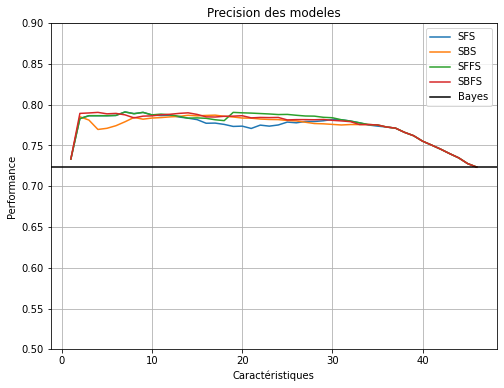

In [22]:
plt.figure(figsize=(8,6))
plt.plot(nbr,avgSfs,label = "SFS")
plt.plot(nbr,avgSbs,label = "SBS")
plt.plot(nbr,avgSffs,label = "SFFS")
plt.plot(nbr,avgSbfs,label = "SBFS")
plt.axhline(y = avgBayes,label = "Bayes",color = "black")
plt.legend()
plt.xlabel('Caractéristiques')
plt.ylabel('Performance')
plt.ylim([0.5, 0.9])
plt.title('Precision des modeles')
plt.grid()
plt.show()

## Calcul des scores AUC

In [23]:
#Sequential Forward Selection AUc scores
sfsAuc = SFS(estimator = GaussianNB(), 
           k_features=featureNbr, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=10,
           n_jobs= -1)

#on complète notre pipeline
pipeSfsAuc = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sfs",sfsAuc)])
pipeSfsAuc.fit(X_train,y_train)
auc = pd.DataFrame.from_dict(pipeSfsAuc['sfs'].get_metric_dict()).T
aucSfs = auc['avg_score'] 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.2s finished

[2021-01-10 15:01:59] Features: 1/46 -- score: 0.7366458668964366[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished

[2021-01-10 15:01:59] Features: 2/46 -- score: 0.806677885190037[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.3s finished

[2021-01-10 15:02:00] Features: 3/46 -- score: 0.8233028147005805[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  43 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.3s finished

[2021-01-10 15:02:00] Features: 4/46 -- score: 0.832

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished

[2021-01-10 15:02:13] Features: 32/46 -- score: 0.8447788785997974[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.4s finished

[2021-01-10 15:02:14] Features: 33/46 -- score: 0.8441975052148447[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished

[2021-01-10 15:02:14] Features: 34/46 -- score: 0.8435790135067857[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 ou

In [24]:
#Sequential Backward Selection auc scores
sbsAuc = SFS(estimator = GaussianNB(), 
           k_features=1, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=10,
           n_jobs = -1)

#on complète notre pipeline
pipeSbsAuc = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sbs",sbsAuc)])

pipeSbsAuc.fit(X_train,y_train) 

auc = pd.DataFrame.from_dict(pipeSbsAuc['sbs'].get_metric_dict()).T
aucSbs = auc['avg_score'] 

#on ordonne les scores
aucSbs = aucSbs.sort_index(ascending = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  46 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.6s finished

[2021-01-10 15:02:31] Features: 45/1 -- score: 0.8282959511920016[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished

[2021-01-10 15:02:33] Features: 44/1 -- score: 0.8298784745889238[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.4s finished

[2021-01-10 15:02:34] Features: 43/1 -- score: 0.8329041249917403[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2021-01-10 15:03:03] Features: 14/1 -- score: 0.8463493852792631[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished

[2021-01-10 15:03:03] Features: 13/1 -- score: 0.8469447029434413[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.1s finished

[2021-01-10 15:03:03] Features: 12/1 -- score: 0.8470747996193808[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out o

In [25]:
#Sequential Forward floating Selection AUC scores
sffsAuc = SFS(estimator = GaussianNB(), 
           k_features=featureNbr, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='roc_auc',
           cv=10,
          n_jobs=-1)

#on complète notre pipeline
pipeSffsAuc = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sffs",sffsAuc)])
pipeSffsAuc.fit(X_train,y_train) 

auc = pd.DataFrame.from_dict(pipeSffsAuc['sffs'].get_metric_dict()).T
aucSffs = auc['avg_score'] 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.2s finished

[2021-01-10 15:03:07] Features: 1/46 -- score: 0.7366458668964366[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-01-10 15:03:08] Features: 2/46 -- score: 0.806677885190037[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  44 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2021-01-10 15:03:16] Features: 17/46 -- score: 0.84784515778393[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2021-01-10 15:03:17] Features: 18/46 -- score: 0.8476967278974386[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out o

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.2s finished

[2021-01-10 15:03:30] Features: 22/46 -- score: 0.8467646073687888[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2021-01-10 15:03:30] Features: 23/46 -- score: 0.8465641443273929[Parallel(n_jobs=-1)]: Using b

[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2021-01-10 15:03:50] Features: 24/46 -- score: 0.8462325232432842[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.4s finished

[2021-01-10 15:03:51] Features: 25/46 -- score: 0.8460009300386446[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using b

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.7s finished

[2021-01-10 15:04:14] Features: 33/46 -- score: 0.8441975052148447[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.7s finished

[2021-01-10 15:04:15] Features: 34/46 -- score: 0.8435790135067857[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out

In [27]:
#Sequential Backward floating Selection AUC scores
sbfsAuc = SFS(estimator = GaussianNB(), 
           k_features=1, 
           forward=False, 
           floating=True, 
           verbose=2,
           scoring='roc_auc',
           cv=10,
          n_jobs=-1)

#on complète notre pipeline
pipeSbfsAuc = Pipeline(steps = [("preprocessor",preprocessor),
                         ("sbfs",sbfsAuc)])

pipeSbfsAuc.fit(X_train,y_train)

auc = pd.DataFrame.from_dict(pipeSbfsAuc['sbfs'].get_metric_dict()).T
aucSbfs = auc['avg_score'] 

#on ordonne les scores 
aucSbfs = aucSbfs.sort_index(ascending = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  46 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.8s finished

[2021-01-10 15:07:14] Features: 45/1 -- score: 0.8282959511920016[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-01-10 15:07:16] Features: 44/1 -- score: 0.8298784745889238[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s

[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.3s finished

[2021-01-10 15:07:42] Features: 28/1 -- score: 0.8459049213266786[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.3s finished

[2021-01-10 15:07:43] Features: 27/1 -- score: 0.8459452024990147[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished

[2021-01-10 15:07:59] Features: 15/1 -- score: 0.8463900123563606[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    0.3s finished

[2021-01-10 15:08:00] Features: 16/1

[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished

[2021-01-10 15:08:10] Features: 10/1 -- score: 0.8466620194558259[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.3s finished

[2021-01-10 15:08:10] Features: 9/1 -- score: 0.8461700519293525[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using back

### Visualisation des scores AUC

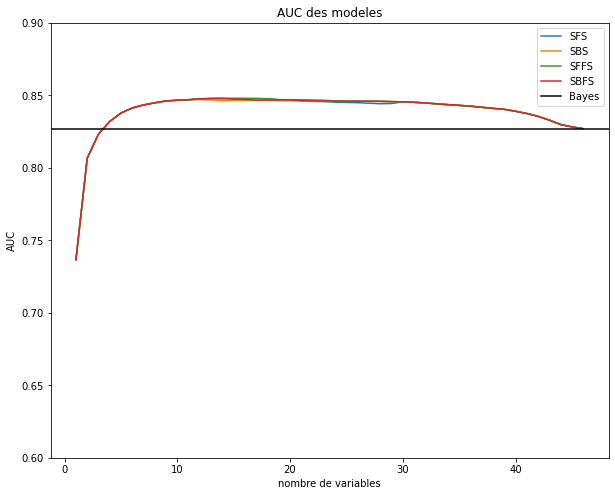

In [28]:
#figure AUc
plt.figure(figsize=(10,8))
plt.title('AUC des modeles')
plt.plot(nbr,aucSfs,label = "SFS")
plt.plot(nbr,aucSbs,label = "SBS")
plt.plot(nbr,aucSffs,label = "SFFS")
plt.plot(nbr,aucSbfs,label = "SBFS")
plt.axhline(y = avgAuc,label = "Bayes",color = "black")
plt.ylim([0.6 ,0.9])
plt.xlabel('nombre de variables')
plt.ylabel('AUC')
plt.legend()
plt.show()




## Tableau des performances et des scores AUC

In [29]:
#On affiche les perfomance de chaque modele

#Dataframe des perforamnces
performance_data ={
    'feature number' : nbr,
    'Naive Bayes': scores,
    'SfS' : avgSfs,
    'SBS' : avgSbs,
    'SFFS': avgSffs,
    'SBFS': avgSbfs
}

perfDF = pd.DataFrame(performance_data)


#Dataframe des scores AUC
auc_data = {
    'feature number' : nbr,
    'Naive Bayes' :aucBayes ,
    'SFS' : aucSfs,
    'SBS' : aucSbs,
    'SFFS' : aucSffs,
    'SBFS' : aucSbfs,
    
}

aucDF = pd.DataFrame(auc_data)

aucDF.head()

,feature number,Naive Bayes,SFS,SBS,SFFS,SBFS
1,1,0.827046,0.736646,0.736646,0.736646,0.736646
2,2,0.827046,0.806678,0.806678,0.806678,0.806678
3,3,0.827046,0.823303,0.823303,0.823303,0.823303
4,4,0.827046,0.832044,0.832044,0.832044,0.832044
5,5,0.827046,0.837858,0.837858,0.837858,0.837858


In [32]:
aucDF.to_excel("auc.xlsx")

In [33]:
perfDF.to_excel('accuracy.xlsx')

## Performances sur les Données de test

In [34]:
from sklearn.metrics import plot_confusion_matrix

In [38]:
from sklearn.metrics import classification_report
X_test.loc[:,'Total Charges']=pd.to_numeric(X_train.loc[:,'Total Charges'], errors = 'coerce')
naive = GaussianNB()
#SFS

X_train_sfs = pipeSfs.transform(X_train)
X_test_sfs = pipeSfs.transform(X_test)


naive.fit(X_train_sfs,y_train)
y_pred = naive.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))
print(classification_report(y_test, y_pred))


Test set accuracy: 79.28 %
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1042
           1       0.64      0.47      0.54       367

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



C:\Users\Nebil\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


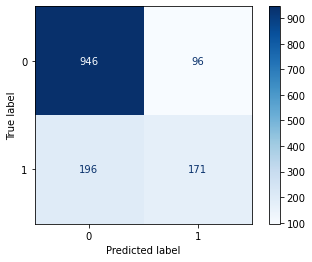

In [39]:
#Confusion matrix
plot_confusion_matrix(naive,X_test_sfs, y_test,cmap = 'Blues')

In [40]:
#SBS

X_train_sfs = pipeSbs.transform(X_train)
X_test_sfs = pipeSbs.transform(X_test)


naive.fit(X_train_sfs,y_train)
y_pred = naive.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

print(classification_report(y_test, y_pred))

Test set accuracy: 78.07 %
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      1042
           1       0.56      0.70      0.62       367

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.79      1409



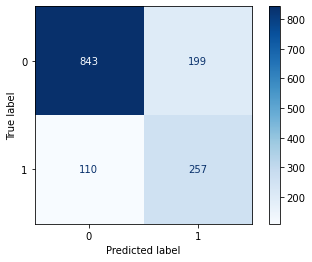

In [41]:
#Confusion matrix
plot_confusion_matrix(naive,X_test_sfs, y_test,cmap = 'Blues')

In [42]:
#SFFS

X_train_sfs = pipeSffs.transform(X_train)
X_test_sfs = pipeSffs.transform(X_test)


naive.fit(X_train_sfs,y_train)
y_pred = naive.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

print(classification_report(y_test, y_pred))

Test set accuracy: 79.28 %
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1042
           1       0.64      0.47      0.54       367

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



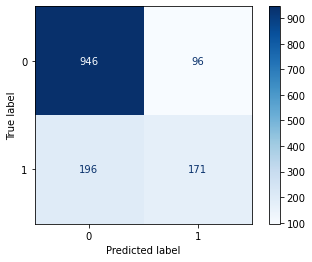

In [43]:
#Confusion matrix
plot_confusion_matrix(naive,X_test_sfs, y_test,cmap = 'Blues')

In [44]:
#SBFS

X_train_sfs = pipeSbfs.transform(X_train)
X_test_sfs = pipeSbfs.transform(X_test)


naive.fit(X_train_sfs,y_train)
y_pred = naive.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

print(classification_report(y_test, y_pred))

Test set accuracy: 70.40 %
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      1042
           1       0.38      0.21      0.27       367

    accuracy                           0.70      1409
   macro avg       0.57      0.54      0.54      1409
weighted avg       0.66      0.70      0.67      1409



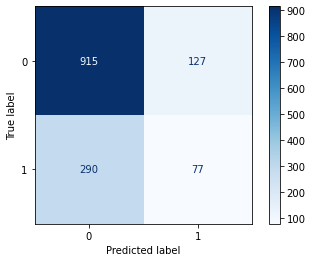

In [45]:
#Confusion matrix
plot_confusion_matrix(naive,X_test_sfs, y_test,cmap = 'Blues')